<a href="https://colab.research.google.com/github/Peony8899/Geospatial-Data-Science-Study/blob/main/Flooding.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import ee
import geemap

In [3]:
ee.Authenticate()
ee.Initialize(project='ee-pwa115')

In [4]:
# "USGS/SRTMGL1_003" is the Earth Engine asset ID for elevation data captured by the SRTM mission.
# ee.Image restrieves the image from tha specified Earth Engine asset ID
srtm=ee.Image("USGS/SRTMGL1_003")

#Inspect the result
srtm

Name,Description
elevation,Elevation


In [5]:
srtm.get("title").getInfo()

'NASA SRTM Digital Elevation 30m'

In [6]:
#he .projection() method provides information about the spatial characteristics of the image, including the CRS.
# .crs() retrieves ons crs info from the result of .projection()
srtm.projection().crs()

In [7]:
#每个pixel代表的地面距离
srtm.projection().nominalScale()

In [8]:
metadata= srtm.getInfo()

#Inpect the result
metadata

{'type': 'Image',
 'bands': [{'id': 'elevation',
   'data_type': {'type': 'PixelType',
    'precision': 'int',
    'min': -32768,
    'max': 32767},
   'dimensions': [1296001, 417601],
   'crs': 'EPSG:4326',
   'crs_transform': [0.0002777777777777778,
    0,
    -180.0001388888889,
    0,
    -0.0002777777777777778,
    60.00013888888889]}],
 'version': 1641990767055141,
 'id': 'USGS/SRTMGL1_003',
 'properties': {'system:visualization_0_min': '0.0',
  'type_name': 'Image',
  'keywords': ['dem',
   'elevation',
   'geophysical',
   'nasa',
   'srtm',
   'topography',
   'usgs'],
  'thumb': 'https://mw1.google.com/ges/dd/images/SRTM90_V4_thumb.png',
  'description': '<p>The Shuttle Radar Topography Mission (SRTM, see <a href="https://onlinelibrary.wiley.com/doi/10.1029/2005RG000183/full">Farr\net al. 2007</a>)\ndigital elevation data is an international research effort that\nobtained digital elevation models on a near-global scale. This\nSRTM V3 product (SRTM Plus) is provided by NASA JP

In [9]:
print("Bands information:")
print(metadata["bands"])
print('\n')
print("Properties:")
print(metadata["properties"])

Bands information:
[{'id': 'elevation', 'data_type': {'type': 'PixelType', 'precision': 'int', 'min': -32768, 'max': 32767}, 'dimensions': [1296001, 417601], 'crs': 'EPSG:4326', 'crs_transform': [0.0002777777777777778, 0, -180.0001388888889, 0, -0.0002777777777777778, 60.00013888888889]}]


Properties:
{'system:visualization_0_min': '0.0', 'type_name': 'Image', 'keywords': ['dem', 'elevation', 'geophysical', 'nasa', 'srtm', 'topography', 'usgs'], 'thumb': 'https://mw1.google.com/ges/dd/images/SRTM90_V4_thumb.png', 'description': '<p>The Shuttle Radar Topography Mission (SRTM, see <a href="https://onlinelibrary.wiley.com/doi/10.1029/2005RG000183/full">Farr\net al. 2007</a>)\ndigital elevation data is an international research effort that\nobtained digital elevation models on a near-global scale. This\nSRTM V3 product (SRTM Plus) is provided by NASA JPL\nat a resolution of 1 arc-second (approximately 30m).</p><p>This dataset has undergone a void-filling process using open-source data\n(A

In [10]:
# Create a dictionary to define visualization settings
srtm_vis_param= {
    'min':0,    # Minimum elevation value
    'max':6000,    # Maximum elevation value
     # Color palette for visualization specified as hexadecimal color codes. , I chose these colour using https://colorbrewer2.org/
    'palette': ['#ffffe5','#fff7bc','#fee391','#fec44f','#fe9929','#ec7014','#cc4c02','#993404','#662506'],
}

# Create a Map instance from geemap
srtm_vis = geemap.Map()

# Add the ee.Image srtm to the map and specify the visualization parameter
#  Set the layer name to "Elevation Data"
srtm_vis.addLayer(srtm, srtm_vis_param,  "Elevation Data")

# add LayerControl to the map
srtm_vis.addLayerControl()

# Display the map
srtm_vis

Map(center=[0, 0], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDataGUI(childr…

<Axes: >

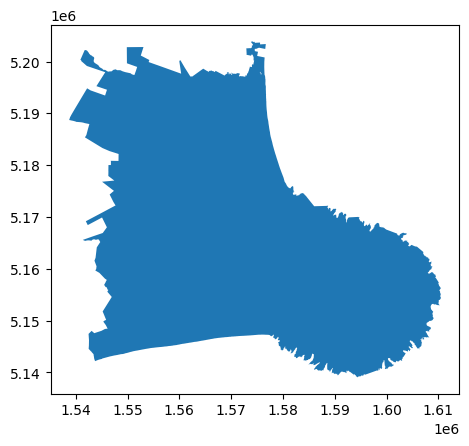

In [12]:
import geopandas as gpd

limits= gpd.read_file('study_area.gpkg')
limits.plot()

<Axes: >

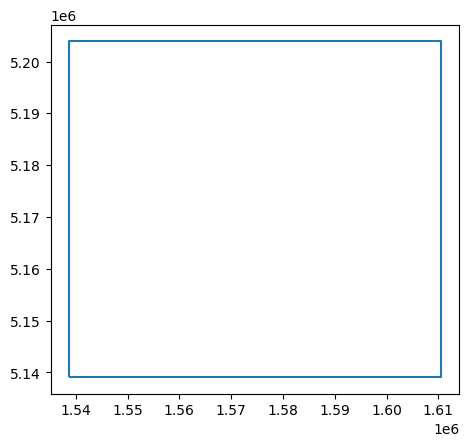

In [13]:
# The envelope of a geometry is the smallest bounding box that contains the geometry
# The boundary function is applied to the envelope to obtain the boundary geometry,
# which is a LineString representing the outer boundary of the envelope.
limits.envelope.boundary.plot()

In [14]:
import numpy as np

# Create a list of coordinates by iterating through each vertex of the bounding box boundary
all_coords = [np.dstack(vertex.coords.xy).tolist()[0] for vertex in limits.envelope.boundary.to_crs(4326)]

# Inspect the result
print(all_coords)

[[[172.2371989116238, -43.89914795563117], [173.1305615770355, -43.90161932153406], [173.1293044957875, -43.317664419206515], [172.24454253112387, -43.31524264531035], [172.2371989116238, -43.89914795563117]]]


In [15]:
# Create ee.Geometry feature using the extracted coordinates
# to define a region of interest (roi)
roi = ee.Geometry.Polygon(all_coords)

In [16]:
# Clip the image to the specified region
srtm_chc = srtm.clip(roi)

In [17]:
# Calculate the x-coordinate of the centroid
# Transform the bounding box boundary to EPSG 4326 and access the x-coordinate of the centroid
cx = limits.envelope.boundary.to_crs(4326).centroid.x[0]

# Calculate the y-coordinate of the centroid
# Transform the bounding box boundary to EPSG 4326 and access the y-coordinate of the centroid
cy = limits.envelope.boundary.to_crs(4326).centroid.y[0]

In [18]:
# Create a dictionary to define visualization settings
srtm_vis_param = {
    'min': -5,    # Minimum elevation value
    'max': 905,   # Maximum elevation value
    'opacity': 0.5,  # Opacity of the visualization (0.0 to 1.0)
    # Color palette for visualization specified as hexadecimal color codes.
    # I chose these colors using https://colorbrewer2.org/
    'palette': ['#ffffe5', '#fff7bc', '#fee391', '#fec44f', '#fe9929', '#ec7014', '#cc4c02', '#993404', '#662506'],
}


# Create a Map instance from geemap with specified center and zoom level
# Set the center of the map to the centroid coordinates
srtm_vis = geemap.Map(center=[cy, cx], zoom=10)

# Load an ee.Image (srtm_chc) and add it to the map with the specified visualization parameters
# Set the layer name to "Elevation Data"
srtm_vis.addLayer(srtm_chc, srtm_vis_param, "Elevation Data")

# Add LayerControl widget to the map for managing layers
srtm_vis.addLayerControl()

# Extract color palette, minimum, and maximum values from the visualization parameter
colors = srtm_vis_param['palette']
vmin = srtm_vis_param['min']
vmax = srtm_vis_param['max']

# Add a colorbar to the map using Branca
srtm_vis.add_colorbar_branca(colors=colors, vmin=vmin, vmax=vmax, layer_name="Elevation Data")

# Display the interactive map
srtm_vis


Map(center=[-43.60927096386118, 172.68539815593962], controls=(WidgetControl(options=['position', 'transparent…

In [19]:
# Calculate slope. Units are degrees, range is [0,90].
slope_chc=ee.Terrain.slope(srtm_chc)

In [20]:
# Create a dictionary to define visualization settings
slope_vis_param = {
    'min': 0,           # Minimum slope value
    'max': 90,          # Maximum slope value
    'opacity': 0.5,     # Opacity of the visualization (0.0 to 1.0)
    # Color palette for visualization specified as hexadecimal color codes.
    # I chose these colors using https://colorbrewer2.org/
    'palette': ['blue', 'red', 'red', 'red', 'red', 'red'],
}

# Create a Map instance from geemap with specified center and zoom level
# Set the center of the map to the centroid coordinates
slope_vis = geemap.Map(center=[cy, cx], zoom=10)

# Load an ee.Image (slope_chc) and add it to the map with the specified visualization parameters
# Set the layer name to "Slope in degrees"
slope_vis.addLayer(slope_chc, slope_vis_param, "Slope in degrees")

# Add LayerControl widget to the map for managing layers
slope_vis.addLayerControl()

# Extract color palette, minimum, and maximum values from the visualization parameter
colors = slope_vis_param['palette']
vmin = slope_vis_param['min']
vmax = slope_vis_param['max']

# Add a colorbar to the map using Branca
slope_vis.add_colorbar_branca(colors=colors, vmin=vmin, vmax=vmax, layer_name="Slope in degrees")

# Display the interactive map
slope_vis

Map(center=[-43.60927096386118, 172.68539815593962], controls=(WidgetControl(options=['position', 'transparent…

In [21]:
# Calculate aspect. Units are degrees where 0=N, 90=E, 180=S, 270=W.
aspect_chc=ee.Terrain.aspect(srtm_chc)

In [23]:
# Create a dictionary to define visualization settings
aspect_vis_param = {
    'min': 0,           # Minimum aspect value (compass direction)
    'max': 360,         # Maximum aspect value (compass direction)
    'opacity': 0.5,     # Opacity of the visualization (0.0 to 1.0)
    # Color palette for visualization specified as color names.
    # These colors will be used to represent different aspect directions.
    'palette': ['red', 'green', 'blue', 'yellow'],
}

# Create a Map instance from geemap with specified center and zoom level
# Set the center of the map to the centroid coordinates
aspect_vis = geemap.Map(center=[cy, cx], zoom=10)

# Load an ee.Image (aspect_chc) and add it to the map with the specified visualization parameters
# Set the layer name to "Aspect in degrees"
aspect_vis.addLayer(aspect_chc, aspect_vis_param, "Aspect in degrees")

# Add LayerControl widget to the map for managing layers
aspect_vis.addLayerControl()

# Extract color palette, minimum, and maximum values from the visualization parameter
colors = aspect_vis_param['palette']
vmin = aspect_vis_param['min']
vmax = aspect_vis_param['max']

# Add a colorbar to the map using Branca
aspect_vis.add_colorbar_branca(colors=colors, vmin=vmin, vmax=vmax, layer_name="Aspect in degrees")

# Display the interactive map
aspect_vis

Map(center=[-43.60927096386118, 172.68539815593962], controls=(WidgetControl(options=['position', 'transparent…

In [24]:
# Define the export parameters
# Specify the image to be exported (srtm_chc)
image = srtm_chc

# Description for the exported task. This will be the description shown ont the GEE Code Editor
description = 'export_dem'

# Folder in Google Drive where the exported data will be stored. If the folder does not exist, it will be created
folder = 'GEE lab'

# Scale of the exported image (in meters per pixel)
scale = 30

# Coordinate Reference System (CRS) for the exported image (e.g., EPSG:2193)
crs = 'EPSG:2193'

# Initialize an Earth Engine batch export task
# Create an export task using Export.image.toDrive
task = ee.batch.Export.image.toDrive(
    image=image,
    description=description,
    folder=folder,
    region=roi,
    scale=scale,
    crs=crs
)

# Start the export task
task.start()

In [25]:
task.status()

{'state': 'COMPLETED',
 'description': 'export_dem',
 'priority': 100,
 'creation_timestamp_ms': 1727679244853,
 'update_timestamp_ms': 1727679352347,
 'start_timestamp_ms': 1727679253362,
 'task_type': 'EXPORT_IMAGE',
 'destination_uris': ['https://drive.google.com/#folders/1xVXqKbomFSAydRRPhXjJRW2QYuHfAPQD'],
 'attempt': 1,
 'batch_eecu_usage_seconds': 8.289199829101562,
 'id': 'QBNE2INMONYYQ6D3ZDGWP2XI',
 'name': 'projects/ee-pwa115/operations/QBNE2INMONYYQ6D3ZDGWP2XI'}

In [26]:
# Define start and end dates using ee.Date objects
start_date = ee.Date('2023-01-01')
end_date = ee.Date('2023-01-10')

# Create an ee.DateRange using the start and end dates
date_range = ee.DateRange(start_date, end_date)

# Define a geometry (point) using longitude and latitude coordinates
geom = ee.Geometry.Point(172.617, -43.531)

# You can also define the area of interest using bounding box coordinates as [xmin, ymin, xmax, ymax]
# Uncomment the following line if you want to use a bounding box geometry instead
# geom = ee.Geometry.Rectangle([172.605, -43.540, 172.629, -43.522])


In [27]:
# Load and filter the image collection based on dates and location
s2_collection = ee.ImageCollection('COPERNICUS/S2_SR').filterBounds(geom).filterDate(date_range)

# Print the number of images in the filtered collection
collection_size = s2_collection.size()
print('Data type for s2_collection: ', type(s2_collection))
print('Number of Images in Filtered Collection:', collection_size.getInfo())

Data type for s2_collection:  <class 'ee.imagecollection.ImageCollection'>
Number of Images in Filtered Collection: 2


In [28]:
# Get the size of the Sentinel-2 image collection
count = s2_collection.size()

# Convert the collection to a list of images and iterate over them
# Print the image IDs
image_list = s2_collection.toList(count)
for i in range(count.getInfo()):
    # Get the current image from the list
    image = ee.Image(image_list.get(i))

    # Print the image ID
    print("Image ID:", image.id().getInfo())

Image ID: 20230103T222541_20230103T222543_T59GPM
Image ID: 20230108T222539_20230108T222541_T59GPM


In [29]:
# Use `.get()` method to query the first image
# Convert the collection to a list of images and get the first image (index 0)
s2_img = ee.Image(s2_collection.toList(count).get(0))

# Alternatively, we also can select the first (i.e., earliest) image in the sorted collection
# Sort the collection by 'system:time_start' (acquisition time) in ascending order
# s2_sorted = s2_collection.sort('system:time_start')
# Get the first (earliest) image from the sorted collection
# s2_img = s2_sorted.first()

In [30]:
# Check the available keys
print(s2_img.getInfo().keys())

dict_keys(['type', 'bands', 'version', 'id', 'properties'])


In [31]:
# Use keys to get specific information
print(s2_img.getInfo()['bands']) # get bands information
print('\n')
print('Cloud coverage is: ', s2_img.getInfo()['properties']['CLOUD_COVERAGE_ASSESSMENT']) # get cloud cover

[{'id': 'B1', 'data_type': {'type': 'PixelType', 'precision': 'int', 'min': 0, 'max': 65535}, 'dimensions': [1830, 1830], 'crs': 'EPSG:32759', 'crs_transform': [60, 0, 600000, 0, -60, 5200000]}, {'id': 'B2', 'data_type': {'type': 'PixelType', 'precision': 'int', 'min': 0, 'max': 65535}, 'dimensions': [10980, 10980], 'crs': 'EPSG:32759', 'crs_transform': [10, 0, 600000, 0, -10, 5200000]}, {'id': 'B3', 'data_type': {'type': 'PixelType', 'precision': 'int', 'min': 0, 'max': 65535}, 'dimensions': [10980, 10980], 'crs': 'EPSG:32759', 'crs_transform': [10, 0, 600000, 0, -10, 5200000]}, {'id': 'B4', 'data_type': {'type': 'PixelType', 'precision': 'int', 'min': 0, 'max': 65535}, 'dimensions': [10980, 10980], 'crs': 'EPSG:32759', 'crs_transform': [10, 0, 600000, 0, -10, 5200000]}, {'id': 'B5', 'data_type': {'type': 'PixelType', 'precision': 'int', 'min': 0, 'max': 65535}, 'dimensions': [5490, 5490], 'crs': 'EPSG:32759', 'crs_transform': [20, 0, 600000, 0, -20, 5200000]}, {'id': 'B6', 'data_type

In [32]:
geemap.ee_initialize()

s2_collection

Name,Description
B1,Aerosols
B2,Blue
B3,Green
B4,Red
B5,Red Edge 1
B6,Red Edge 2
B7,Red Edge 3
B8,NIR
B8A,Red Edge 4
B9,Water vapor


In [33]:
# First we need to scale the image bands to values between 0 and 1.
# The value to devide by comes from the Earth Engine Catalog scale 0.00001 here: https://developers.google.com/earth-engine/datasets/catalog/COPERNICUS_S2_SR#description
# This is often done to rescale the data from 16-bit to floating-point values (0 to 1 range)
s2_img = s2_img.divide(10000)

In [34]:
# Get the x and y coordinates from the geometry and convert them to Python variables
# These coordinates represent the longitude (x) and latitude (y) values of the point geometry
# we used to filter when searching the Image Collection

# Get the x-coordinate (longitude) from the geometry's coordinates and convert to Python variable
cx = geom.coordinates().get(0).getInfo()

# Get the y-coordinate (latitude) from the geometry's coordinates and convert to Python variable
cy = geom.coordinates().get(1).getInfo()

# Define visualization parameters for Sentinel-2 data
# These parameters specify which bands to use for visualization and the data range

# Define the bands for visualization as ['B4', 'B3', 'B2']
# These correspond to the red, green, and blue bands, respectively
# This combination creates a natural color image

# Set the minimum value for visualization to 0
# Set the maximum value for visualization to 1
# This range is used to visualize reflectance values in a normalized range
s2_vis_param = {
    'bands': ['B4', 'B3', 'B2'],
    'min': 0,
    'max': 1
}

In [35]:
# Create a Map instance from geemap with a specified center and zoom level
# The map will be centered at the coordinates [cy, cx] and zoomed to level 9
s2_vis = geemap.Map(center=[cy, cx], zoom=9)

# Load an ee.Image (s2_img) and add it to the map with the specified visualization parameters
# The layer will be named "Sentinel R(B4)G(B3)B(B2)"
s2_vis.addLayer(s2_img, s2_vis_param, "Sentinel R(B4)G(B3)B(B2)")

# Add a LayerControl widget to the map for managing layers
s2_vis.addLayerControl()

# Display the interactive map with the added layers and controls
s2_vis

Map(center=[-43.531, 172.617], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDa…

In [36]:
# Create a region of interest (ROI) by buffering the geometry and extracting its bounding box
buffered_geom = geom.buffer(1000)

# Extract the bounding box of the buffered geometry to define the region
# This defines the spatial extent for analysis within the buffered area
region = buffered_geom.bounds()

# Define the list of bands (channels) to export
channels = ['B4', 'B3', 'B2']

In [40]:
# Export the clipped image to your local folder

# Clip the Sentinel-2 image (s2_img) to the defined region of interest
# The result is stored in the 'clipped' variable
clipped = s2_img.clip(region)

# Select specific bands (channels) from the clipped image for export
# Use the 'channels' list defined earlier to select the specified bands
selected_channels = clipped.select(channels)

# Export the selected channels as an image to the specified filename
# The image will be exported to the 'Lab7_data' folder in your local directory
geemap.ee_export_image(selected_channels, filename='E:\\UC-MADS\\GISC412\\lab\\Lab 7 Data-20240930\\S2_img.tif')

Generating URL ...
Please wait ...
Data downloaded to /content/E:\UC-MADS\GISC412\lab\Lab 7 Data-20240930\S2_img.tif


In [41]:
# Map a clipping function over each image in the Sentinel-2 collection (s2_collection)
# The result is a new collection ('clipped') where each image is clipped to the region
clipped = s2_collection.map(lambda x: x.clip(region))

# Export the entire clipped image collection to the specified output directory
# All images in the 'clipped' collection will be exported to the 'Lab7_data' folder
geemap.ee_export_image_collection(clipped, out_dir='Lab7_data')

Total number of images: 2

Exporting 1/2: Lab7_data/20230103T222541_20230103T222543_T59GPM.tif
Generating URL ...
Please wait ...
Data downloaded to /content/Lab7_data/20230103T222541_20230103T222543_T59GPM.tif


Exporting 2/2: Lab7_data/20230108T222539_20230108T222541_T59GPM.tif
Generating URL ...
Please wait ...
Data downloaded to /content/Lab7_data/20230108T222539_20230108T222541_T59GPM.tif




(205, 204, 3)


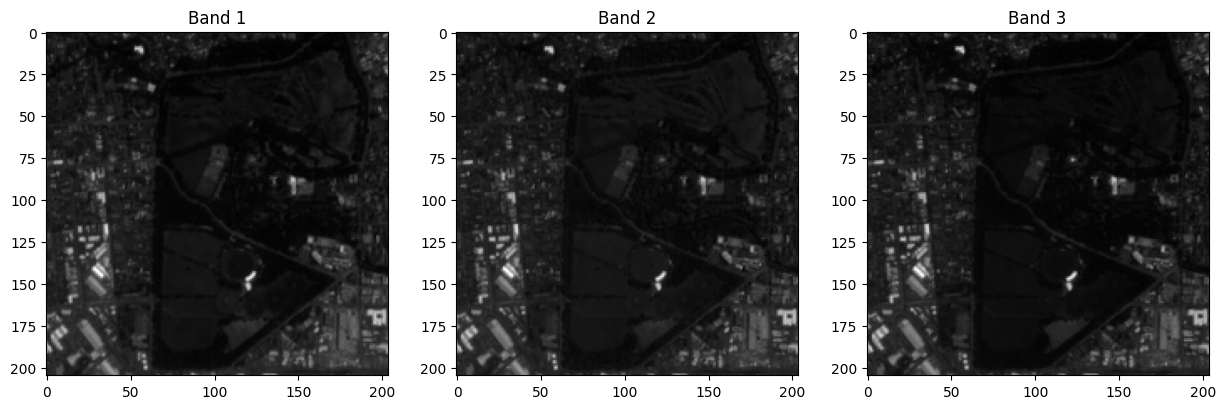

In [42]:
# Extract Pixels as Numpy ndarray

# Convert the Earth Engine image 's2_img' to a numpy ndarray
# Select specific bands (channels) using the 'channels' list
# The region of interest for extraction is defined by the 'region' variable
img_array = geemap.ee_to_numpy(s2_img.select(channels), region=region)

# Print the shape of the extracted numpy ndarray
# The shape represents the dimensions of the ndarray (rows, columns, bands)
print(img_array.shape)

# Display each band using the 'matplotlib' library
import matplotlib.pyplot as plt

# Create a figure with 'num_bands' subplots arranged in a row
fig, ax = plt.subplots(1, img_array.shape[2], figsize=(5 * img_array.shape[2], 5))

# Loop over the bands and display each one as an image in a separate subplot
for i in range(img_array.shape[2]):
    ax[i].imshow(img_array[:, :, i], cmap='gray')
    ax[i].set_title(f'Band {i+1}')

# Display the figure
plt.show()

In [43]:
# Define function to compute NDVI
# This function calculates the Normalized Difference Vegetation Index (NDVI) for an input image.

def compute_ndvi(img):
    # Calculate NDVI by normalizing the difference between near-infrared (B8) and red (B4) bands
    ndvi = img.normalizedDifference(['B8', 'B4']).rename('ndvi')

    # Add the computed NDVI band to the input image
    return img.addBands(ndvi)

In [44]:
# Calculate NDVI using the 'compute_ndvi' function on the Sentinel-2 image 's2_img'
# The function computes NDVI and adds the NDVI band to the image
# Select the 'ndvi' band from the computed NDVI image
ndvi = compute_ndvi(s2_img).select(['ndvi'])

In [45]:
# Define visualization parameters for NDVI image

# Specify that the 'ndvi' band should be used for visualization
# Set the minimum value for visualization to -1 and the maximum value to 1
# This range represents the typical NDVI values from -1 to 1, indicating vegetation health.

# Choose a color palette for visualization using hexadecimal color codes
# The palette represents a gradient from negative values (pink) to positive values (green).
# Color palette for visualization specified as hexadecimal color codes.
# I chose these colors using https://colorbrewer2.org/
ndvi_vis_param = {
    'bands': ['ndvi'],
    'min': -1,
    'max': 1,
    'palette': ['#d01c8b', '#f1b6da', '#f7f7f7', '#b8e186', '#4dac26']
}

In [46]:
# Create a map instance ('ndvi_vis') using the geemap library.
# Set the center of the map at the coordinates [cy, cx] and zoom to level 9.
ndvi_vis = geemap.Map(center=[cy, cx], zoom=9)

# Load the NDVI image ('ndvi') and add it to the map with specified visualization parameters.
# The layer will be named "NDVI" and will use the settings defined in 'ndvi_vis_param'.
ndvi_vis.addLayer(ndvi, ndvi_vis_param, "NDVI")

# Add a LayerControl widget to the map for managing layers.
# This widget allows users to toggle layers on and off in the map interface.
ndvi_vis.addLayerControl()

# Extract color palette, minimum, and maximum values from the visualization parameter.
colors = ndvi_vis_param['palette']
vmin = ndvi_vis_param['min']
vmax = ndvi_vis_param['max']

# Add a colorbar to the map using Branca.
# The colorbar visually represents the range of NDVI values using the specified color palette.
ndvi_vis.add_colorbar_branca(colors=colors, vmin=vmin, vmax=vmax, layer_name="NDVI")

# Display the interactive map with the added layers, controls, and colorbar.
ndvi_vis

Map(center=[-43.531, 172.617], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDa…

In [47]:
!pip install pycrs

  Preparing metadata (setup.py) ... done
  Created wheel for pycrs: filename=PyCRS-1.0.2-py3-none-any.whl size=32686 sha256=588d4456ace59e9132d94b931292994559555ea99382a31c06e566c4cd9841f7
  Stored in directory: /root/.cache/pip/wheels/47/1d/70/7a5bdf33347e7c75e95b06b1fa38f076a59a9506653cc24aff
Successfully built pycrs


In [49]:
# Define area of interest using shapefile uploaded
# Convert the shapefile 'Lab7_data/ncrs.shp' to an Earth Engine geometry object.
aoi = geemap.shp_to_ee('ncrs.shp')
aoi

In [50]:
# Define start and end date for image collection
# Define the start and end dates for filtering the Sentinel-2 image collection.
start_date = '2021-10-01'
end_date = '2022-04-01'

# Load the Sentinel-2 surface reflectance image collection ('COPERNICUS/S2_SR').
# Filter the collection to include images within the defined AOI and date range.
# Further filter images with a cloudy pixel percentage less than or equal to 10%.
# Apply the 'compute_ndvi' function to compute NDVI value for each image.
s2_sr = ee.ImageCollection('COPERNICUS/S2_SR') \
    .filterBounds(aoi) \
    .filterDate(start_date, end_date) \
    .filter(ee.Filter.lte('CLOUDY_PIXEL_PERCENTAGE', 10)) \
    .map(compute_ndvi)  # Compute NDVI value for each image

# Select NDVI band from the processed image collection
s2_ndvi = s2_sr.select(['ndvi'])

# Print the number of images in the collection
print("Number of images in collection: ", s2_ndvi.size().getInfo())

# The code below exports the images to the local disk. This is just for you reference. Do not run it
# as it might cause storage issues in your JupyterHub
# clipped = s2_ndvi.map(lambda x: x.clip(aoi.toList(s2_ndvi.size()).get(0)))
# geemap.ee_export_image_collection(clipped, out_dir='Lab7_data')

Number of images in collection:  10


In [53]:
# Define a function for reducing region statistics for charting

# This function, named 'extractStats', is used to calculate various statistics
# for an input image within the specified region of interest (AOI).

def extractStats(image):
    # Use the 'reduceRegions' function to calculate statistics for the image within the AOI.
    return image.reduceRegions(**{
        'collection': aoi,  # The collection parameter specifies the region of interest (AOI).
        'reducer': ee.Reducer.minMax()\
            .combine(ee.Reducer.median(), '', True)\
            .combine(ee.Reducer.mean(), '', True),
        # The 'reducer' parameter defines the combination of reducers to be applied.
        # MinMax, median, and mean reducers are combined to calculate various statistics.
        # The empty separator '' is used to concatenate the names of the reducers.
        # The `True` argument specifies that the output should include both input and result bands.
          })

In [54]:
# Define a function for adding date as a band to each image

# This function, named 'addDate', is used to add a new band representing the image date
# to each input image.

def addDate(image):
    # Get the date of the image and format it as YYYYMMdd.
    img_date = ee.Date(image.date())
    img_date = ee.Number.parse(img_date.format('YYYYMMdd'))

    # Add the formatted date as a new band named 'date' to the input image.
    return image.addBands(ee.Image(img_date).rename('date').toInt())

In [55]:
S2NDVI = s2_ndvi.map(addDate).map(extractStats).flatten()
# flatten the resulting feature collection into a single collection of features

S2NDVI

In [56]:
# S2NDVI.first().getInfo() # inspect the first record

df_columns = list(S2NDVI.first().getInfo()['properties'].keys())

In [57]:
# Feature collection (mapped) to data frame with reducer
nested_list = S2NDVI.reduceColumns(ee.Reducer.toList(len(df_columns)), df_columns).values().get(0)

# nested_list.getInfo()

In [58]:
# Import the 'pandas' library for working with DataFrames.
import pandas as pd

# Call the 'getInfo' callback method to retrieve the Earth Engine data as Python objects.
# Create a DataFrame from the retrieved data with specified column names.
# The DataFrame will have columns as per the defined column names.

df = pd.DataFrame(nested_list.getInfo(), columns=df_columns)

# Process and organize the DataFrame

# Convert the 'date_min' column to a Pandas datetime format ('YYYYMMdd' to datetime).
# Sort the DataFrame by the 'date' column to organize the data chronologically.

df['date'] = pd.to_datetime(df['date_min'], format='%Y%m%d')
df_new = df.sort_values(by=['date'])

# Print the organized DataFrame.
df_new

,Id,date_max,date_mean,date_median,date_min,ndvi_max,ndvi_mean,ndvi_median,ndvi_min,date
0,0,20211015,20211015,20211015,20211015,0.566740,0.482887,0.478913,0.426559,2021-10-15
1,0,20211106,20211106,20211106,20211106,0.250150,0.206848,0.205298,0.186848,2021-11-06
2,0,20211224,20211224,20211224,20211224,0.935264,0.924427,0.925226,0.905646,2021-12-24
3,0,20211231,20211231,20211231,20211231,0.937535,0.925854,0.925244,0.912918,2021-12-31
4,0,20220103,20220103,20220103,20220103,0.943231,0.932584,0.932240,0.924317,2022-01-03
5,0,20220115,20220115,20220115,20220115,0.800279,0.746826,0.749923,0.649072,2022-01-15
6,0,20220214,20220214,20220214,20220214,0.593935,0.557921,0.568185,0.303103,2022-02-14
7,0,20220224,20220224,20220224,20220224,0.205488,0.150877,0.144343,0.129940,2022-02-24
8,0,20220314,20220314,20220314,20220314,0.213159,0.146826,0.139136,0.126539,2022-03-14
9,0,20220316,20220316,20220316,20220316,0.185852,0.145046,0.141210,0.132197,2022-03-16


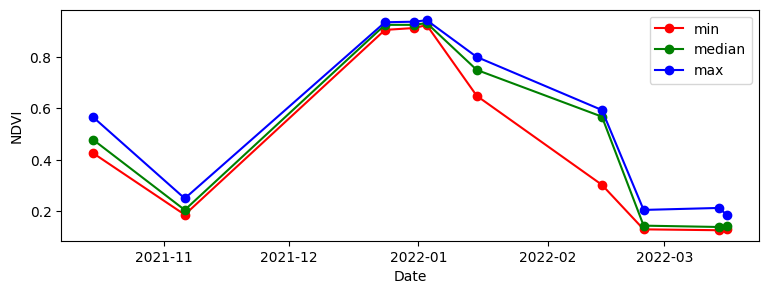

In [59]:
# Create a figure and axis for the plot.
fig, ax = plt.subplots(figsize=(9, 3))

# Plot the 'ndvi_min', 'ndvi_median', and 'ndvi_max' columns against the 'date' column.
# Each statistic is plotted as a series of points with lines ('o-') in different colors.
# The colors 'r' (red), 'g' (green), and 'b' (blue) represent 'ndvi_min', 'ndvi_median', and 'ndvi_max' respectively.
# Legend labels are provided for each series.
ax.plot(df['date'], df['ndvi_min'], 'o-', color='r', label="min")
ax.plot(df['date'], df['ndvi_median'], 'o-', color='g', label="median")
ax.plot(df['date'], df['ndvi_max'], 'o-', color='b', label="max")

# Add a legend to the plot indicating the meaning of each series.
plt.legend(loc="best")

# Set labels for the x-axis and y-axis.
ax.set_xlabel('Date')
ax.set_ylabel('NDVI')

# Display the plot.
plt.show()

In [61]:
aoi = geemap.shp_to_ee('Hastings.shp')
# Map = geemap.Map(center=[-39.545, 176.891], zoom=9)
# Map.addLayer(aoi)
# Map

In [62]:
# Set start and end dates of a period BEFORE the flood
before_start = '2023-01-21'
before_end = '2023-01-31'

# Set start and end dates of a period AFTER the flood
after_start = '2023-02-10'
after_end = '2023-02-15'

In [63]:
polarization = 'VH' # or 'VV'

In [64]:
pass_direction = 'ASCENDING' # or 'DESCENDING'

In [65]:
difference_threshold = 1.25

In [66]:
## Load and filter Sentinel-1 Ground Range Detected (GRD) data by predefined parameters
# https://developers.google.com/earth-engine/datasets/catalog/COPERNICUS_S1_GRD
collection= ee.ImageCollection('COPERNICUS/S1_GRD')\
  .filter(ee.Filter.eq('instrumentMode','IW'))\
  .filter(ee.Filter.listContains('transmitterReceiverPolarisation', polarization))\
  .filter(ee.Filter.eq('orbitProperties_pass',pass_direction))\
  .filter(ee.Filter.eq('resolution_meters',10))\
  .filterBounds(aoi)\
  .select(polarization)

In [67]:
before_collection = collection.filterDate(before_start, before_end)
after_collection = collection.filterDate(after_start,after_end)

In [68]:
## Create a mosaic of selected tiles and clip to study area
before = before_collection.mosaic().clip(aoi)
after = after_collection.mosaic().clip(aoi)

In [69]:
## Apply reduce the radar speckle by smoothing
smoothing_radius = 50
before_filtered = before.focal_mean(smoothing_radius, 'circle', 'meters')
after_filtered = after.focal_mean(smoothing_radius, 'circle', 'meters')

In [70]:
import geemap

Map = geemap.Map(center=[-39.545, 176.891], zoom=15, width=600)

vis = {'bands': polarization, 'region': aoi, 'min':-25, 'max':0,}

left_layer = geemap.ee_tile_layer(after, vis, name = 'before filtering',)

right_layer = geemap.ee_tile_layer(after_filtered, vis, name = 'after filtering',)

Map.split_map(left_layer, right_layer)
Map

Map(center=[-39.545, 176.891], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zo…

In [71]:
# Calculate the difference between the before and after images
difference = after_filtered.divide(before_filtered)

# Apply the predefined difference-threshold and create the flood extent mask
threshold = difference_threshold
difference_binary = difference.gt(threshold)

In [72]:
# # Import the Image function from the IPython.display module.
from IPython.display import display, Image

# # Display a thumbnail
img = Image(url = difference_binary\
            .getThumbURL({'region': aoi.geometry().bounds(),
                          'scale': 30,
                          #  set a lower image resolution for display to avoid the oversize error
                          'min':0, 'max':1}
                          # The `min` and `max` arguments control the stretch of the color map
                        ), width=600)

display(img)

In [73]:
## Refine flood result using additional datasets

# Include JRC layer on surface water seasonality to mask flood pixels from areas
# of "permanent" water (where there is water > 10 months of the year)
# https://developers.google.com/earth-engine/datasets/catalog/JRC_GSW1_4_GlobalSurfaceWater
swater = ee.Image('JRC/GSW1_0/GlobalSurfaceWater').select('seasonality')
swater_mask = swater.gte(10).updateMask(swater.gte(10))

# https://developers.google.com/earth-engine/apidocs/ee-image-updatemask

# Flooded layer where perennial water bodies (water > 10 mo/yr) is assigned a 0 value
flooded_mask = difference_binary.where(swater_mask,0)
# final flooded area without pixels in perennial waterbodies
flooded = flooded_mask.updateMask(flooded_mask)

# Compute connectivity of pixels to eliminate those connected to 8 or fewer neighbours
# This operation reduces noise of the flood extent product
connections = flooded.connectedPixelCount()
flooded = flooded.updateMask(connections.gte(8));

# Mask out areas with more than 5 percent slope using a Digital Elevation Model
DEM = ee.Image('WWF/HydroSHEDS/03VFDEM')
terrain = ee.Algorithms.Terrain(DEM)
slope = terrain.select('slope')
flooded = flooded.updateMask(slope.lt(5));

In [74]:
# Calculate flood extent area
# Create a raster layer containing the area information of each pixel
flood_pixelarea = flooded.select(polarization)\
  .multiply(ee.Image.pixelArea())

In [75]:
# Sum the areas of flooded pixels
# default is set to 'bestEffort: False' in order to reduce compuation time, for a more
# accurate result set bestEffort to True and increase 'maxPixels'.
flood_stats = flood_pixelarea.reduceRegion(**{
  'reducer': ee.Reducer.sum(),
  'geometry': aoi,
  'scale': 10, # native resolution
  'bestEffort': True
  })

# Convert the flood extent to hectares (area calculations are originally given in meters)
flood_area_ha = flood_stats\
  .getNumber(polarization)\
  .divide(10000)\
  .round()

print("Estimated flood extent:", str(flood_area_ha.getInfo()) + " hectares")

Estimated flood extent: 7444 hectares


In [76]:
# SAR imagery is not as easy to interpret visually as optical remote sensing.
# Selecting area that have been identified to display as a new layer can help in interpretation.
import geemap

Map = geemap.Map(center=[-39.545, 176.891], zoom=12, width=600)
Map.addLayer(aoi)
Map.addLayer(after_filtered,
             {'bands': polarization,
              'region': aoi,
              'min':-25, 'max':0,})
Map.addLayer(flood_pixelarea,
             {'bands': polarization,
              'region': aoi,
              'min':0, 'max':1,
              'palette': 'blue'})

Map

Map(center=[-39.545, 176.891], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDa…

In [77]:
# # Convert flood raster to polygons
flooded_vec = flooded.reduceToVectors(**{
    'scale': 10,
    'geometryType':'polygon',
    'geometry': aoi,
    'eightConnected': False,
    'bestEffort':True,
    'tileScale':2,
})

geemap.ee_export_vector(flooded_vec, "Lab7_data/flooded_vec.shp", verbose=True)

Generating URL ...
Please wait ...
Data downloaded to /content/Lab7_data/flooded_vec.shp


In [80]:
Map.to_html(filename= 'E:\\UC-MADS\\GISC412\\lab\\Lab 7 Data-20240930\\flood_map.html', title='flood_map', width='100%', height='1200px')

## Note: JupyterHub may not allow opening; right click on .html in sidebar and open in New Browser Tab.